In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cancer-classification-challenge-2024/sampleSubmission.csv
/kaggle/input/cancer-classification-challenge-2024/train.csv
/kaggle/input/cancer-classification-challenge-2024/test/image_32415.jpg
/kaggle/input/cancer-classification-challenge-2024/test/image_16454.jpg
/kaggle/input/cancer-classification-challenge-2024/test/image_36989.jpg
/kaggle/input/cancer-classification-challenge-2024/test/image_4378.jpg
/kaggle/input/cancer-classification-challenge-2024/test/image_41366.jpg
/kaggle/input/cancer-classification-challenge-2024/test/image_13094.jpg
/kaggle/input/cancer-classification-challenge-2024/test/image_58146.jpg
/kaggle/input/cancer-classification-challenge-2024/test/image_65084.jpg
/kaggle/input/cancer-classification-challenge-2024/test/image_50895.jpg
/kaggle/input/cancer-classification-challenge-2024/test/image_14675.jpg
/kaggle/input/cancer-classification-challenge-2024/test/image_62128.jpg
/kaggle/input/cancer-classification-challenge-2024/test/image_64927.jpg
/kag

Initial class distribution:
 Diagnosis
0    47684
1    25735
Name: count, dtype: int64


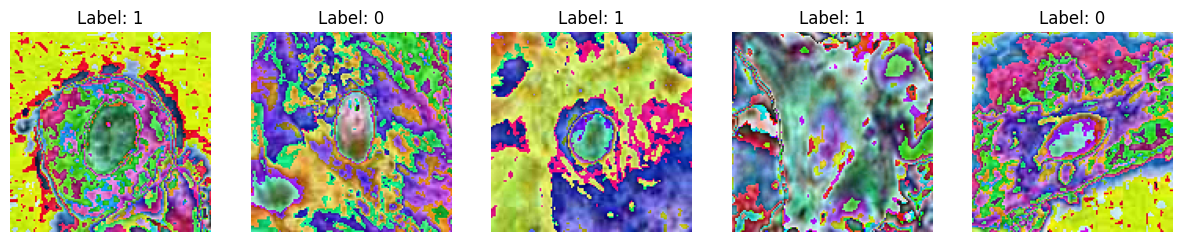

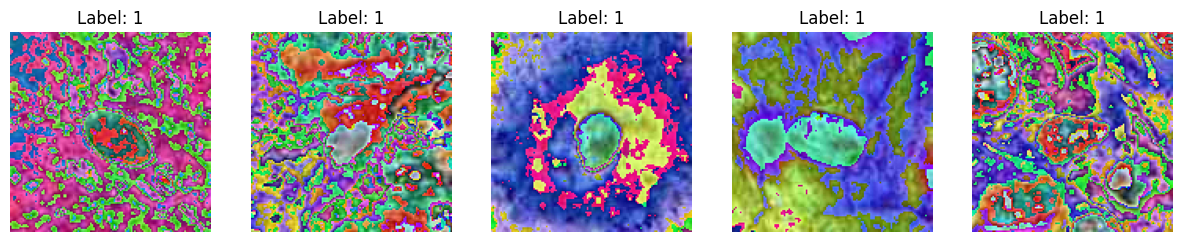

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image

csv_path = '/kaggle/input/cancer-classification-challenge-2024/train.csv'
path_to_train_images = '/kaggle/input/cancer-classification-challenge-2024/train'
path_to_test_images = '/kaggle/input/cancer-classification-challenge-2024/test'

# Define the paths
data_dir = '/kaggle/input/cancer-classification-challenge-2024'
csv_path = '/kaggle/input/cancer-classification-challenge-2024/train.csv'
image_folder = os.path.join(data_dir, 'train')

# Load the CSV file
data_df = pd.read_csv(csv_path)
class_counts = data_df['Diagnosis'].value_counts()
print("Initial class distribution:\n", class_counts)

# Split data into training and validation sets
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=42)

# Save split data to separate CSV files
train_csv_path = '/kaggle/working/train.csv'
val_csv_path = '/kaggle/working/val_split.csv'
train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)

# Custom dataset class
class CancerDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(int(self.annotations.iloc[idx, 1]))

        if self.transform:
            image = self.transform(image)

        return image, label


class BalancedCancerDataset(Dataset):
    def __init__(self, annotations_file, img_dir, standard_transform=None, augment_transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.standard_transform = standard_transform
        self.augment_transform = augment_transform

        # Separate the minority and majority class samples
        self.minority_class = self.annotations[self.annotations['Diagnosis'] == 1]
        self.majority_class = self.annotations[self.annotations['Diagnosis'] == 0]

        # Calculate the number of samples needed to balance the dataset
        self.num_minority_samples = len(self.minority_class)
        self.num_majority_samples = len(self.majority_class)
        self.num_samples_needed = self.num_majority_samples - self.num_minority_samples

    def __len__(self):
        return len(self.annotations) + self.num_samples_needed

    def __getitem__(self, idx):
        if idx < len(self.annotations):
            # Use original data
            img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
            image = Image.open(img_path).convert("RGB")
            label = int(self.annotations.iloc[idx, 1])
            if self.standard_transform:
                image = self.standard_transform(image)
        else:
            # Generate augmented samples for the minority class
            idx = idx - len(self.annotations)
            img_path = os.path.join(self.img_dir, self.minority_class.iloc[idx % self.num_minority_samples, 0])
            image = Image.open(img_path).convert("RGB")
            label = 1
            if self.augment_transform:
                image = self.augment_transform(image)

        return image, torch.tensor(label)


# Define standard and augmentation transformations
standard_transforms = transforms.Compose([
    transforms.Resize((128, 128)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

augment_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image

])

# Load training dataset with balanced sampling
train_dataset = BalancedCancerDataset(
    annotations_file=train_csv_path,
    img_dir=image_folder,
    standard_transform=standard_transforms,
    augment_transform=augment_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Load validation dataset without augmentation
val_dataset = CancerDataset(
    annotations_file=val_csv_path,
    img_dir=image_folder,
    transform=standard_transforms,
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)


# Visualize a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (img, lbl) in enumerate(zip(images[:5], labels[:5])):
    axes[i].imshow(transforms.ToPILImage()(img))
    axes[i].set_title(f"Label: {lbl.item()}")
    axes[i].axis('off')
plt.show()

dataiter = iter(val_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (img, lbl) in enumerate(zip(images[:5], labels[:5])):
    axes[i].imshow(transforms.ToPILImage()(img))
    axes[i].set_title(f"Label: {lbl.item()}")
    axes[i].axis('off')
plt.show()


In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)

In [ ]:
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.se1 = SEBlock(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 1)  # Output layer with 1 neuron for binary classification
        self.dropout = nn.Dropout(0.5)  # Dropout with dropout probability 0.5

        # Initialize weights using Kaiming He initialization
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv3.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv4.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv5.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))
        x = self.pool(F.relu(self.conv5_bn(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x.squeeze()


Epoch [1/40], Train Loss: 44.1262, Train Accuracy: 0.7210, Val Loss: 16.7440, Val Accuracy: 0.6939
0.001
Epoch [2/40], Train Loss: 14.3104, Train Accuracy: 0.7553, Val Loss: 16.8368, Val Accuracy: 0.7250
0.001
Epoch [3/40], Train Loss: 13.9066, Train Accuracy: 0.7655, Val Loss: 15.7357, Val Accuracy: 0.7438
0.001
Epoch [4/40], Train Loss: 13.6122, Train Accuracy: 0.7786, Val Loss: 16.6149, Val Accuracy: 0.7316
0.001
Epoch [5/40], Train Loss: 13.0634, Train Accuracy: 0.7946, Val Loss: 15.2114, Val Accuracy: 0.7619
0.001
Epoch [6/40], Train Loss: 12.3558, Train Accuracy: 0.8064, Val Loss: 15.9615, Val Accuracy: 0.7575
0.001
Epoch [7/40], Train Loss: 11.8111, Train Accuracy: 0.8183, Val Loss: 12.8697, Val Accuracy: 0.8082
0.001
Epoch [8/40], Train Loss: 11.1453, Train Accuracy: 0.8334, Val Loss: 12.0689, Val Accuracy: 0.8211
0.0002
Epoch [9/40], Train Loss: 9.7990, Train Accuracy: 0.8577, Val Loss: 10.8989, Val Accuracy: 0.8366
0.0002
Epoch [10/40], Train Loss: 9.3639, Train Accuracy: 0.8

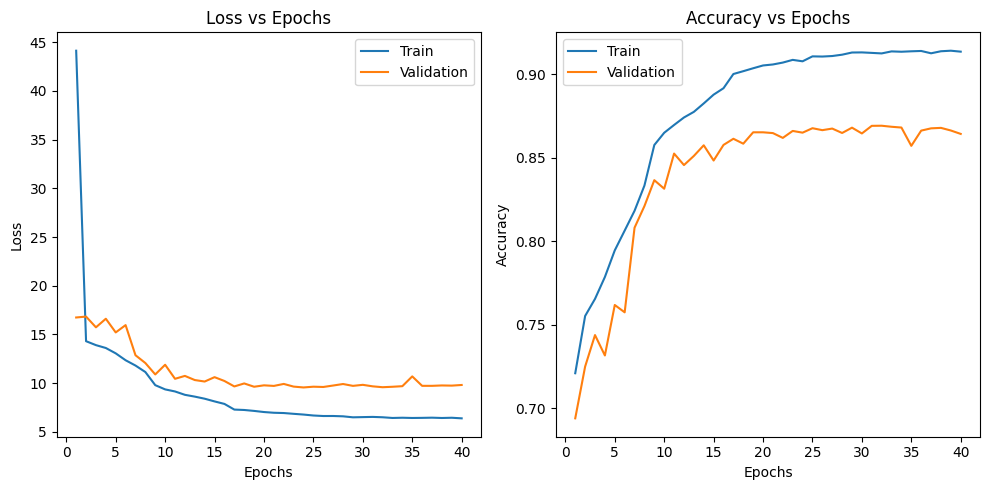

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler
from IPython.display import clear_output

# Define training parameters
batch_size = 64
epochs = 40

# Define model,loss function and optimizer
model = ConvNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.2)  # Decrease LR by a factor of 0.1 every 5 epochs

# Function to compute accuracy
def compute_accuracy(predictions, labels):
    predicted_classes = (torch.sigmoid(predictions) > 0.5).float()
    correct = (predicted_classes == labels).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    total_samples = 0

    i=0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            total_loss += loss.item() * len(labels)
            total_accuracy += compute_accuracy(outputs, labels)
            total_samples += len(labels)
            i+=1

    avg_loss = total_loss / i
    avg_accuracy = total_accuracy / i
    return avg_loss, avg_accuracy


# Load training dataset with balanced classes
train_dataset = BalancedCancerDataset(
    annotations_file=train_csv_path,
    img_dir=image_folder,
    standard_transform=standard_transforms,
    augment_transform=augment_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Load validation dataset (no augmentation needed)
val_dataset = CancerDataset(
    annotations_file=val_csv_path,
    img_dir=image_folder,
    transform=standard_transforms,
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

#------------TRAINING----------------#

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
epoch_iter = 0
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    j = 0


    for i, (images, labels) in enumerate(train_loader):
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(labels)
        running_accuracy += compute_accuracy(outputs, labels).item()

        j+=1


    avg_train_loss = running_loss / j
    avg_train_accuracy = running_accuracy / j

    # Evaluate on validation set
    val_loss, val_accuracy = evaluate_model(model, val_loader)

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Update the learning rate
    scheduler.step()
    print(optimizer.param_groups[0]['lr'])

    # Collect metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy.item())

    epoch_iter+=1

# Plotting
plt.figure(figsize=(10, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train')
plt.plot(range(1, epochs + 1), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/model_weights.pth')


In [1]:
# Define the paths
test_folder = '/kaggle/input/cancer-classification-challenge-2024/test'

#----------------Even though the accuracy on val set is fine, and auc high, the predicitons are all classified as cancer patients--------------#

# Custom dataset class for test data
class TestDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.img_paths = [os.path.join(folder, img_name) for img_name in os.listdir(folder)]
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, os.path.basename(img_path)  # Return image and filename

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load test dataset
test_dataset = TestDataset(folder=test_folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Compute predictions
def predict(model, data_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, filenames in data_loader:
            images = images.to(device)
            outputs = torch.sigmoid(model(images))

            for output, filename in zip(outputs, filenames):
                predictions.append((filename, output.item()))

    return predictions


test_predictions = predict(model, test_loader)
print("HEY")

predictions_df = pd.DataFrame(test_predictions, columns=['Name', 'Diagnosis'])

# Save predictions to CSV file
predictions_df.to_csv('/kaggle/working/test_predictions.csv', index=False)

print("Predictions saved to 'test_predictions.csv'")


NameError: name 'Dataset' is not defined

In [ ]:
from sklearn.metrics import roc_auc_score

y_pred_proba = model.predict(X_val)


In [ ]:
auc = roc_auc_score(y_val, y_pred_proba)
print(f"AUC Score on Validation Set: {auc}")

In [ ]:
from sklearn.metrics import roc_auc_score
model.eval()

def predict_and_evaluate(model, dataloader, device):
    model.to(device)
    y_true = []
    y_pred_proba = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            y_pred_proba.extend(probs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    auc = roc_auc_score(y_true, y_pred_proba)
    return auc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate AUC on validation set
auc_score = predict_and_evaluate(model, val_loader, device)
print(f"AUC Score on Validation Set: {auc_score}")


AUC Score on Validation Set: 0.9394908053292933


In [ ]:
val_loss, val_accuracy = evaluate_model(model, val_loader)

In [ ]:
print(val_accuracy)

tensor(0.8643, device='cuda:0')
